# replicate the sine model to check if we can deploy the model onto the MCU

In [79]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
import math

### check if mps support is available -metal performance shaders

In [2]:
torch.backends.mps.is_available()

True

In [3]:
torch.backends.mps.is_built()

True

In [4]:
# we can use it by setting the mps device
mps = torch.device("mps")
cpu = torch.device("cpu")

## create data 

In [5]:
SAMPLES = 1000
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

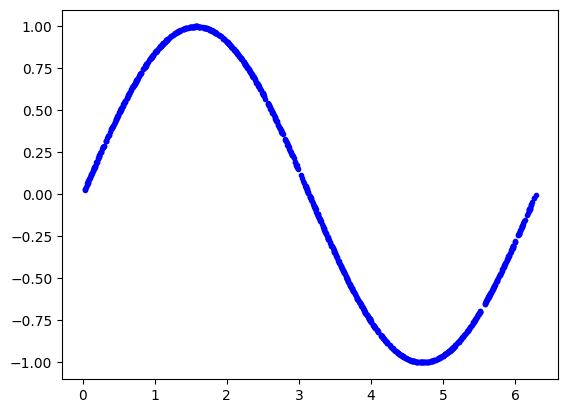

In [6]:
# generate random numbers
x_values = np.random.uniform(low=0, high=2*math.pi, size=SAMPLES)

# shuffle the values
np.random.shuffle(x_values)

# calculate corresponding y values
y_values = np.sin(x_values)
plt.plot(x_values, y_values, 'b.')
plt.show()

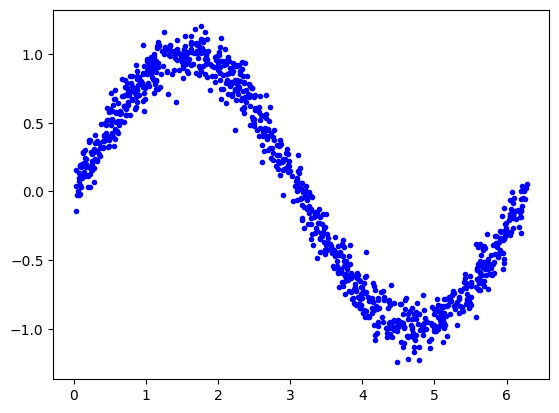

In [7]:
# add noise
y_values += 0.1 * np.random.randn(y_values.shape[0])

plt.plot(x_values, y_values, 'b.')
plt.show()

In [52]:
TRAIN_SPLIT = int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

x_train, x_validate, x_test = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_validate, y_test = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

In [57]:
torch.unsqueeze(torch.tensor(0.5041235, dtype=torch.float), dim=0).shape

torch.Size([1])

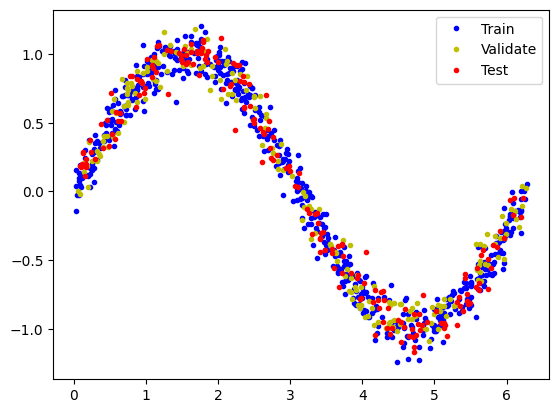

In [58]:
# Plot the data in each partition in different colors:
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_validate, y_validate, 'y.', label="Validate")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.legend()
plt.show()

# model

In [127]:
# shape should resemble the one used in the tensorflow tutorial

class Mlp(nn.Module):
    def __init__(self):
        super(Mlp, self).__init__()
        # input layer
        self.fc1 = nn.Linear(1, 16)
        # hidden layer
        self.fc2 = nn.Linear(16, 16)
        # output layer, no activation
        self.fc3 = nn.Linear(16, 1)
    
    def forward(self, x):
        # forward loop to propagate through the network
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [42]:
params = list(mlp_3.parameters())
print(len(params))
print(params[0].size())

6
torch.Size([16, 1])


In [241]:
def train_one_epoch(model, opti, crit, device, train_data):
    
    # send model to desired device
    model.to(device)

    epoch_train_loss = list()

    for x_train, y_train in train_data:
        x_train = torch.unsqueeze(torch.tensor(x_train), dim=0).float().to(device)
        y_train = torch.unsqueeze(torch.tensor(y_train), dim=0).float().to(device)

        # make prediction
        output = model(x_train)
        # compute loss
        loss = crit(input=output.to(device), target=y_train)
        # zero out gradients
        opti.zero_grad()
        # backward pass
        loss.backward()       
        # optimization step
        opti.step()

        epoch_train_loss.append(loss.detach().cpu().numpy())

    return model, np.average(epoch_train_loss)

In [242]:
def validate(model, val_data, device):
    val_loss = list()

    for x_val, y_val in val_data:
        x_val = torch.unsqueeze(torch.tensor(x_val), dim=0).float().to(device)
        y_val = torch.unsqueeze(torch.tensor(y_val), dim=0).float().to(device)

        assert x_val, y_val
        #prediction
        output = model(x_val)
        # compute loss
        loss = criterion(output, y_val)
        assert loss

        val_loss.append(loss.detach().cpu().numpy())
    
    return np.average(val_loss)

## training on mps

In [252]:
%%time

EPOCHS = 100
LR = 0.001


criterion = nn.MSELoss()

mlp_3 = Mlp()

optimizer = torch.optim.RMSprop(mlp_3.parameters(), lr=LR)

train_loss = list()
val_loss = list()

for epoch in range(EPOCHS):
    # training step
    mlp_3.train()
    
    mlp_3, t_loss_epoch = train_one_epoch(mlp_3, optimizer, criterion, mps, zip(x_train, y_train))
    train_loss.append(t_loss_epoch)
    
    # validation step
    mlp_3.eval()
    
    v_loss_epoch = validate(mlp_3, zip(x_validate, y_validate), mps)
    val_loss.append(v_loss_epoch)
    
    print(f"EPOCH {epoch+1}: Training loss is {t_loss_epoch} - Validation loss is {v_loss_epoch}")

EPOCH 1: Training loss is 0.20434463024139404 - Validation loss is 0.13666540384292603
EPOCH 2: Training loss is 0.10263554751873016 - Validation loss is 0.09821861982345581
EPOCH 3: Training loss is 0.07680331915616989 - Validation loss is 0.0830463245511055
EPOCH 4: Training loss is 0.06758943200111389 - Validation loss is 0.07569951564073563
EPOCH 5: Training loss is 0.06210150942206383 - Validation loss is 0.06933797895908356
EPOCH 6: Training loss is 0.05728843808174133 - Validation loss is 0.06351318210363388
EPOCH 7: Training loss is 0.05293366685509682 - Validation loss is 0.05785688757896423
EPOCH 8: Training loss is 0.04889511689543724 - Validation loss is 0.051920365542173386
EPOCH 9: Training loss is 0.04511820524930954 - Validation loss is 0.04703909903764725
EPOCH 10: Training loss is 0.041583191603422165 - Validation loss is 0.04287084937095642
EPOCH 11: Training loss is 0.03827669844031334 - Validation loss is 0.038392674177885056
EPOCH 12: Training loss is 0.0350968949

EPOCH 93: Training loss is 0.011697085574269295 - Validation loss is 0.010073120705783367
EPOCH 94: Training loss is 0.011680500581860542 - Validation loss is 0.010062397457659245
EPOCH 95: Training loss is 0.01166932750493288 - Validation loss is 0.01005374826490879
EPOCH 96: Training loss is 0.011666868813335896 - Validation loss is 0.010036656633019447
EPOCH 97: Training loss is 0.01165474858134985 - Validation loss is 0.010051362216472626
EPOCH 98: Training loss is 0.0116390660405159 - Validation loss is 0.010033748112618923
EPOCH 99: Training loss is 0.01162963081151247 - Validation loss is 0.010021764785051346
EPOCH 100: Training loss is 0.011618868447840214 - Validation loss is 0.010008714161813259
CPU times: user 2min 2s, sys: 20.8 s, total: 2min 23s
Wall time: 3min


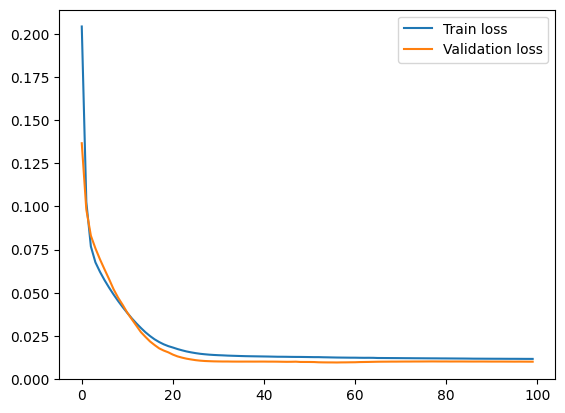

In [255]:
plt.plot(range(EPOCHS),train_loss, label='Train loss')
plt.plot(range(EPOCHS), val_loss, label='Validation loss')
plt.legend()
plt.show()

## Training on cpu

In [256]:
%%time

EPOCHS = 100
LR = 0.001


criterion = nn.MSELoss()

mlp_3 = Mlp()

optimizer = torch.optim.RMSprop(mlp_3.parameters(), lr=LR)

train_loss = list()
val_loss = list()

for epoch in range(EPOCHS):
    # training step
    mlp_3.train()
    
    mlp_3, t_loss_epoch = train_one_epoch(mlp_3, optimizer, criterion, cpu, zip(x_train, y_train))
    train_loss.append(t_loss_epoch)
    
    # validation step
    mlp_3.eval()
    
    v_loss_epoch = validate(mlp_3, zip(x_validate, y_validate), cpu)
    val_loss.append(v_loss_epoch)
    
    print(f"EPOCH {epoch+1}: Training loss is {t_loss_epoch} - Validation loss is {v_loss_epoch}")

EPOCH 1: Training loss is 0.1848503053188324 - Validation loss is 0.1291065663099289
EPOCH 2: Training loss is 0.0976187139749527 - Validation loss is 0.09745218604803085
EPOCH 3: Training loss is 0.07586650550365448 - Validation loss is 0.07957086712121964
EPOCH 4: Training loss is 0.06320008635520935 - Validation loss is 0.06574071198701859
EPOCH 5: Training loss is 0.05312100797891617 - Validation loss is 0.05350365489721298
EPOCH 6: Training loss is 0.04448476806282997 - Validation loss is 0.04271210730075836
EPOCH 7: Training loss is 0.03674959018826485 - Validation loss is 0.033388834446668625
EPOCH 8: Training loss is 0.03007662482559681 - Validation loss is 0.025173921138048172
EPOCH 9: Training loss is 0.024582266807556152 - Validation loss is 0.019013386219739914
EPOCH 10: Training loss is 0.020493291318416595 - Validation loss is 0.015568708069622517
EPOCH 11: Training loss is 0.017814677208662033 - Validation loss is 0.012509074062108994
EPOCH 12: Training loss is 0.0159561

EPOCH 93: Training loss is 0.011345776729285717 - Validation loss is 0.009515335783362389
EPOCH 94: Training loss is 0.011309501715004444 - Validation loss is 0.009539260528981686
EPOCH 95: Training loss is 0.011297532357275486 - Validation loss is 0.00957940798252821
EPOCH 96: Training loss is 0.011294534429907799 - Validation loss is 0.009556403383612633
EPOCH 97: Training loss is 0.011285529471933842 - Validation loss is 0.009565037675201893
EPOCH 98: Training loss is 0.011264721862971783 - Validation loss is 0.00958664808422327
EPOCH 99: Training loss is 0.011210293509066105 - Validation loss is 0.009403223171830177
EPOCH 100: Training loss is 0.011251513846218586 - Validation loss is 0.009377408772706985
CPU times: user 9.46 s, sys: 52.6 ms, total: 9.51 s
Wall time: 9.54 s


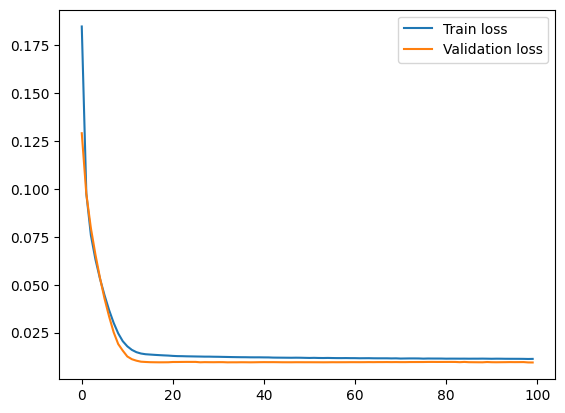

In [257]:
plt.plot(range(EPOCHS),train_loss, label='Train loss')
plt.plot(range(EPOCHS), val_loss, label='Validation loss')
plt.legend()
plt.show()